In [58]:
# Enable Float64 for more stable matrix inversions.
from jax import config
config.update("jax_enable_x64", True)

import numpy as np

import jax.numpy as jnp
from jax import random
from jax import jit

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC

import gpjax as gpx
from kohgpjax.kohkernel import KOHKernel

import matplotlib.pyplot as plt

key = random.PRNGKey(123)

# Problem formulation

To get `gpjax` framework to work, we need to extract the likelihood using the model. This mean the data is stored in `gpjax.Dataset()` and the kernel is constructed using `gpjax` components.

The MATLAB code is just a reparameterised squared exponential kernel. For $x, y \in \mathbb{R}$,
$$
K_{\text{RBF}}(x, y) = \exp\left\{ -\frac{(x - y)^2}{2 \ell^2} \right\}.
$$
The MATLAB kernel is as follows,
$$
K_{\text{MATLAB}}(x, y) = \rho^{4(x-y)^2} = \exp\left\{ -\beta(x - y)^2 \right\}
$$
by using the transformation, $\rho = \exp{\left\{ -\beta/4 \right\}} \iff \beta = -4\log\rho$.
This means we can transform the GPJax RBF outputs to compare them with the MATLAB code by transforming thr variables in the following way
$$
\beta = \frac{1}{2\ell^2},
$$
$$
\rho = e^{-\beta/4} = \exp{\left\{ \frac{-1}{8\ell^2} \right\}}.
$$

## HOWEVER

This will not work for 2 reasons.
1. The GPJax implementation applies the kernel across all input dimensions by using the L2 norm. The MATLAB implementation instead applies the kernel to each individual dimension and then multiplies output from each kernel, thus treating each dimension independently.
2. The MATLAB covariance matrix is built up by using multiples submatrices, $\Sigma_\eta$, $\Sigma_\delta$, $\Sigma_\epsilon$ and $\Sigma_{\epsilon_\eta}$, representing the simulation, discrepancy, observation noise and simulation rounding error resprectively. GPJax does not easily allow for constructing a covariance matrix in this way.

In [59]:
################
##### DATA #####
################

DATAFIELD = np.loadtxt('data/simple_field.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/simple_comp.csv', delimiter=',', dtype=np.float32)

num_obs = DATAFIELD.shape[0]

xf = np.reshape(DATAFIELD[:, 0], (-1, 1))
xc = np.reshape(DATACOMP[:, 0], (-1,1))
tc = np.reshape(DATACOMP[:, 1], (-1,1))
yf = np.reshape(DATAFIELD[:, 1], (-1,1))
yc = np.reshape(DATACOMP[:, 2], (-1,1))



#Standardize full response using mean and std of yc
yc_mean = np.mean(yc)
# yc_std = np.std(yc)
yc_std = np.std(yc, ddof=1) #estimate is now unbiased
x_min = min(xf.min(), xc.min())
x_max = max(xf.max(), xc.max())
t_min = tc.min()
t_max = tc.max()

xf_normalized = (xf - x_min)/(x_max - x_min)
xc_normalized = (xc - x_min)/(x_max - x_min)
# tc_normalized = np.zeros_like(tc)
# for k in range(tc.shape[1]):
#     tc_normalized[:, k] = (tc[:, k] - np.min(tc[:, k]))/(np.max(tc[:, k]) - np.min(tc[:, k]))
tc_normalized = (tc - t_min)/(t_max - t_min)
yc_standardized = (yc - yc_mean)/yc_std
yf_standardized = (yf - yc_mean)/yc_std

# x = jnp.vstack((xf_normalized, xc_normalized))
# t = jnp.vstack((jnp.zeros((xf_normalized.shape[0], tc_normalized.shape[1])) + 0.5, tc_normalized))
# y = jnp.vstack((yf_standardized, yc_standardized))

# data = KOHDataset(X=x, t=t, y=y)

In [60]:
theta = 0.5

x = jnp.vstack((xf_normalized, xc_normalized))
t = jnp.vstack((jnp.zeros((xf_normalized.shape[0], tc_normalized.shape[1])) + theta, tc_normalized))
x = jnp.hstack((x, t))
y = jnp.vstack((yf_standardized, yc_standardized))

data = gpx.Dataset(X=x, y=y)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/gpjax/dataset.py:58: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


In [61]:
product_kernel = gpx.kernels.ProductKernel(kernels=[
        gpx.kernels.RBF(
            active_dims=[0],
            lengthscale=jnp.array(jnp.sqrt(1/50)),
        ), 
        gpx.kernels.RBF(
            active_dims=[1],
            lengthscale=jnp.array(jnp.sqrt(1/7)),
        )
    ])

kernel = KOHKernel(
    k_eta=product_kernel,
    k_delta=gpx.kernels.White(
        active_dims=[0],
        # lengthscale=jnp.array(jnp.sqrt(1/2)),
        variance=jnp.array(1/30)
    ), 
    k_epsilon=gpx.kernels.White(
        active_dims=[0],
        variance=jnp.array(1/1000)
    ),
    k_epsilon_eta=gpx.kernels.White(
        active_dims=[0],
        variance=jnp.array(1/10000)
    ),
    num_obs=num_obs,    
)
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)

In [62]:
num_points = 100

xtest = jnp.linspace(0, 10, num_points).reshape(-1, 1)

# ttest = jnp.linspace(0.2, 0.8, num_points).reshape(-1,1)
ttest = jnp.array([0.4]*num_points).reshape(-1, 1)

xtest = jnp.hstack((xtest, ttest))

prior_dist = prior.predict(xtest)
print(prior_dist)

tfp.distributions.GaussianDistribution("<unknown>", event_shape=([100],))


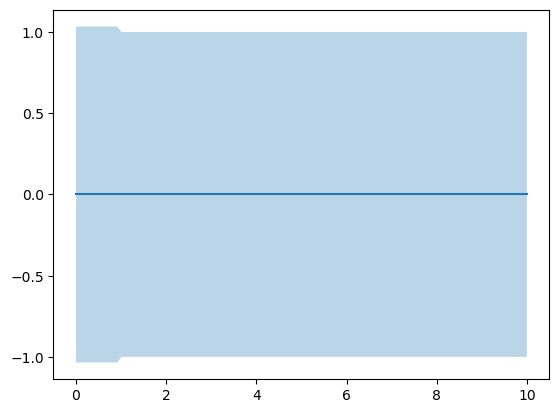

In [63]:
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(5,))

fig, ax = plt.subplots()
# ax.plot(xtest[:,0], samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest[:,0], prior_mean, label="Prior mean")
ax.fill_between(
    xtest[:,0].flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)

In [64]:
likelihood = gpx.likelihoods.Gaussian(
    num_datapoints=data.n,
    obs_stddev=jnp.array(0.0)
)

posterior = prior * likelihood

In [65]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=data)

Array(153.05196541, dtype=float64)

In [66]:
negative_mll = jit(negative_mll)

In [67]:
negative_mll(posterior, train_data=data)

Array(153.05196541, dtype=float64)

Everything below this section is from the jax `tutorial.ipynb` notebook.

In [2]:
n = 100
noise = 0.3

key, subkey = random.split(key)
x = random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + random.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

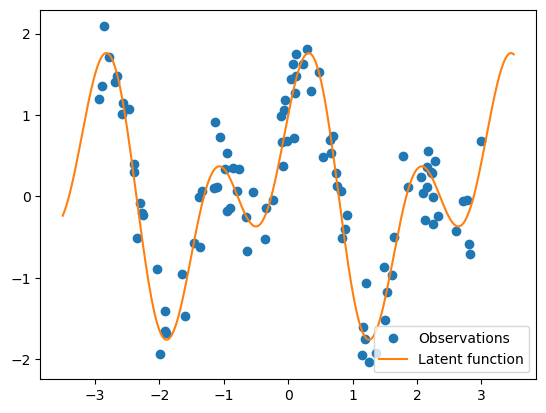

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations")
ax.plot(xtest, ytest, label="Latent function")
ax.legend(loc="best")

In [4]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)

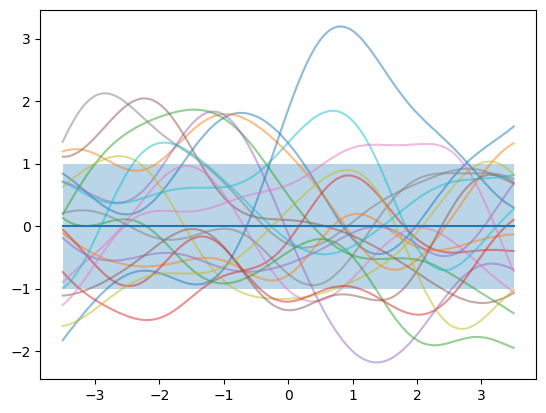

In [5]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest, prior_mean, label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)

In [6]:
likelihood = gpx.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [7]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)


# static_tree = jax.tree_map(lambda x: not(x), posterior.trainables)
# optim = ox.chain(
#     ox.adam(learning_rate=0.01),
#     ox.masked(ox.set_to_zero(), static_tree)
#     )

negative_mll = jit(negative_mll)

In [8]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)

Initial loss is 124.80517341248411
Optimization was successful
Final loss is 55.10368595023454 after 17 iterations
